# Solutions to Exercise 1

[<img src="https://img.shields.io/badge/Documentation-Main_Page-orange.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/)
[<img src="https://img.shields.io/badge/I_Need_Help-Installation-teal.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/installation.html)
[<img src="https://img.shields.io/badge/I_Need_Help-How_To_Run-green.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/running.html)
[<img src="https://img.shields.io/badge/I_Need_Help-Input_Quick_Guide-blue.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/user_inp.html)
[<img src="https://img.shields.io/badge/I_Need_Help-Input_Reference-purple.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/user_ref.html)
[<img src="https://img.shields.io/badge/I_Need_Help-JSON_Output-red.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/program_json.html)

The code cells below show how to set up energy calculations on the water molecule, and how to run the calculations from within the notebook.

In [1]:
import os
import sys
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
from vampyr import vampyr3d as vp

ROOT = os.path.dirname(os.path.abspath(''))
sys.path.append(ROOT)

from utils.functions import MRChemOutput, makeInput, submit
from grid_plotter import grid_plotter

## Loop over the precisions and run calculations

**ProTip**: You could save some time by reusing the MW3 orbitals as starting guess for the higher precision jobs. How to do this is explained in the documentation:

[<img src="https://img.shields.io/badge/I_Need_Help-MW_Initial_Guess-red.svg?logo=LOGO">](https://mrchem.readthedocs.io/en/latest/users/user_inp.html#write-orbitals)

In [2]:
# Uncomment the makeInput and submit commands
# and delete the time.sleep command to run the calculations
precisions = {'mw3': 1e-3, 'mw4': 1e-4, 'mw5': 1e-5}

mw_results = {}
for i, (label, prec) in enumerate(precisions.items()):
    print(label.upper())
    
    jobname = f'water_{label}'
    xyzfile = '../geometries/water.xyz'

    t0 = time.time()
    # makeInput(world_prec=prec, xyzfile=xyzfile, fname=jobname)
    # submit(nprocs=6, inputfile=jobname)
    time.sleep((i+1)**2)
    t1 = time.time()
        
    print(f'   >>> Finished after {t1-t0:.1f} seconds')

MW3
   >>> Finished after 1.0 seconds
MW4
   >>> Finished after 4.0 seconds
MW5
   >>> Finished after 9.0 seconds


## Plot the SCF convergence for each job and store the energies

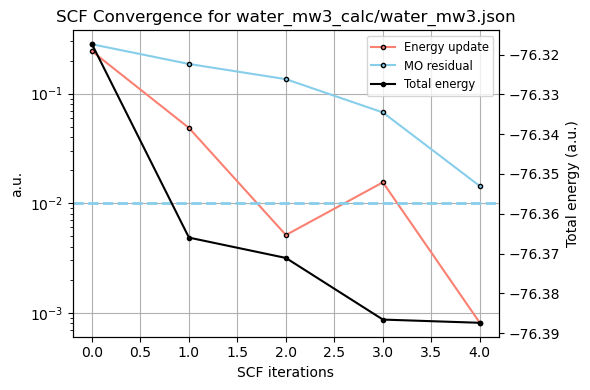

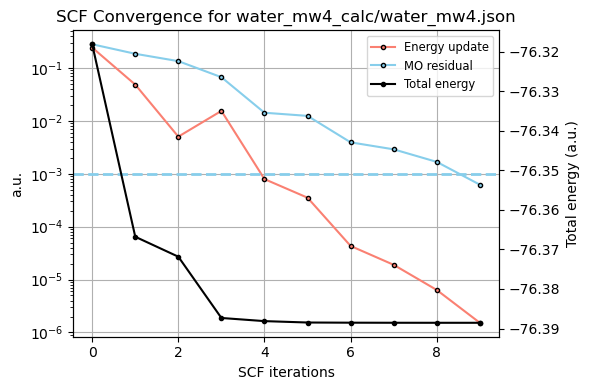

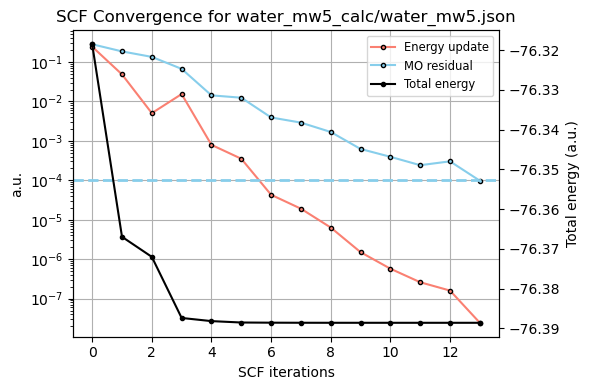

In [3]:
base = 'water'
precisions = {'mw3': 1e-3, 'mw4': 1e-4, 'mw5': 1e-5}

mw_data = []
for label, prec in precisions.items():
    f = os.path.join(f'{base}_{label}_calc', f'{base}_{label}.json')
    calc = MRChemOutput(f)
    mw_data.append((label, calc.getFinalSCFEnergy()))
    calc.plotSCFConvergence()

## Compare to GTOs
Here is an example of how to visualize the data, using `pandas.DataFrame`s and `matplotlib`.

<BarContainer object of 6 artists>

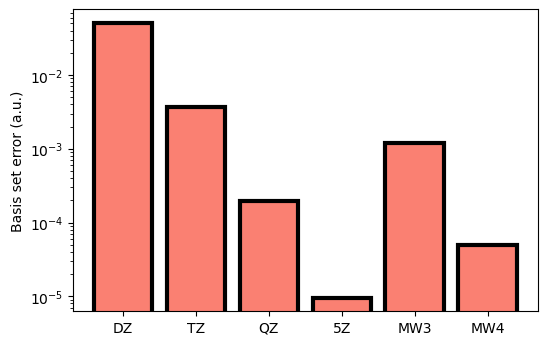

In [4]:
# Make DataFrame
gto_data = [
    ('dz', -76.337833062097),
    ('tz', -76.384930572433),
    ('qz', -76.388407845518),
    ('5z', -76.388593505849)
]

df = pd.DataFrame(gto_data+mw_data, columns=['Basis', 'Energy'])
ref = df.loc[df.Basis == 'mw5']['Energy'].values[0]
df['Error'] = df['Energy'] - ref
df.drop(df.loc[df.Basis == 'mw5'].index, inplace=True)

# Plot
fig, ax = plt.subplots(dpi=100)
ax.set_yscale('log')
ax.set_ylabel('Basis set error (a.u.)')

ax.bar(df.Basis.str.upper(), df.Error, edgecolor='black', color='salmon', lw=3)

# Plot the multiresolution grid from optimized orbital
You can use the orbital files to visualize the optimized multiresolution grid, by using some of the tricks from the `Vampyr` exercises.

You need the `grid_plotted` function for this (see imports at the top of this notebook).

In [5]:
def get_mra(jsonfile):
    """Return a vp.MultiResolutionAnalysis object with 
       parameters read from the JSON output file."""
    with open(jsonfile) as f:
        j = json.loads(f.read())
    
    boxes = j['input']['mra']['boxes']
    corner = j['input']['mra']['corner']
    order = j['input']['mra']['basis_order']
    scale = j['input']['mra']['min_scale']
    
    return vp.MultiResolutionAnalysis(box=vp.BoundingBox(nboxes=boxes, corner=corner, scale=scale), order=order)

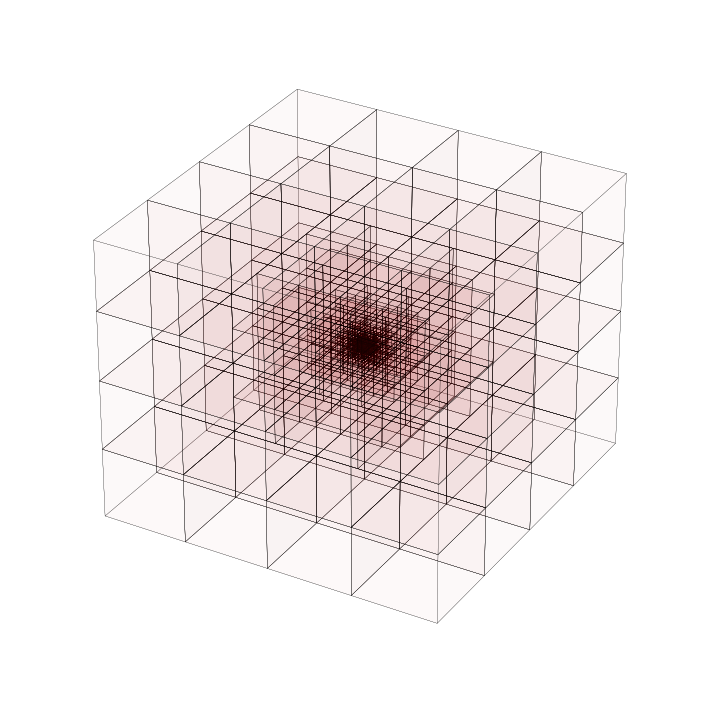

In [6]:
# Use the supplied grid_plotter to visualize the grid
basename = 'water_mw3'
calcdir = basename + '_calc'
orb = os.path.join(calcdir, 'orbitals', f'phi_p_scf_idx_0_re')

mra = get_mra(os.path.join(calcdir, basename+'.json'))
tree = vp.FunctionTree(mra)
tree.loadTree(orb)
fig, ax = grid_plotter(tree=tree)

# fig.savefig(f'MultiResGrid_{basename}.png')